In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import math

from glob import glob

%matplotlib inline

In [2]:
sns.set_style("whitegrid")
current_palette = sns.color_palette("muted")
sns.set_palette(current_palette)

In [3]:
method = "USRCAT_30"
#method = "USRCAT_1"

# Statistical background

In [4]:
def score(dataset, cutoffs):
    cols = [col for col in dataset.columns if (col not in ["name"] and "score" not in col)]
    for c in cutoffs:
        name = "score"+str(c)
        dataset[name] = dataset[dataset[cols] >= c][cols].fillna(0).sum(axis=1)

In [5]:
def gumbel(x, mi, beta):
    z = (x - mi) / beta
    return np.exp(-(z + np.exp(-z))) / beta

In [6]:
cutoffs = [i/10.0 for i in xrange(1,10)]
colnames = ["score"+str(i) for i in cutoffs]
cnum = len(cutoffs)

In [7]:
all_data = pd.DataFrame(columns=["mol", "sample", "size", "cutoff", "score"])

In [8]:
k = 0
for i in glob("../data/statistical_model/results/" + method + "/*tab.bz2"):
    sample = i.split('/')[-1].split('.')[0]
    if k%10 == 0:
        print "processed", k, "samples"
    k += 1
    size = sample.split("_")[-1]
    dataset = pd.read_table(i, sep="\t")
    score(dataset, cutoffs)
    for j in xrange(cnum):
        tmp = dataset[["name", colnames[j]]]
        tmp.columns = ["mol", "score"]
        tmp["cutoff"] = cutoffs[j]
        tmp["size"] = size
        tmp["sample"] = sample
        all_data = pd.concat([all_data, tmp])
print "processed", k, "samples"

processed 0 samples
processed 10 samples
processed 20 samples
processed 30 samples
processed 40 samples
processed 50 samples
processed 57 samples


In [9]:
all_data["size"] = all_data["size"].astype(float)
all_data["score"] = all_data["score"].astype(float)
all_data["cutoff"] = all_data["cutoff"].astype(float)

print all_data.shape
all_data.head()

(51300, 5)


,cutoff,mol,sample,score,size
0,0.1,CHEMBL1302458,sample15_112,63.016824,112.0
1,0.1,CHEMBL117841,sample15_112,55.343469,112.0
2,0.1,CHEMBL2107656,sample15_112,60.289321,112.0
3,0.1,CHEMBL1797611,sample15_112,53.420818,112.0
4,0.1,CHEMBL1822085,sample15_112,63.621182,112.0


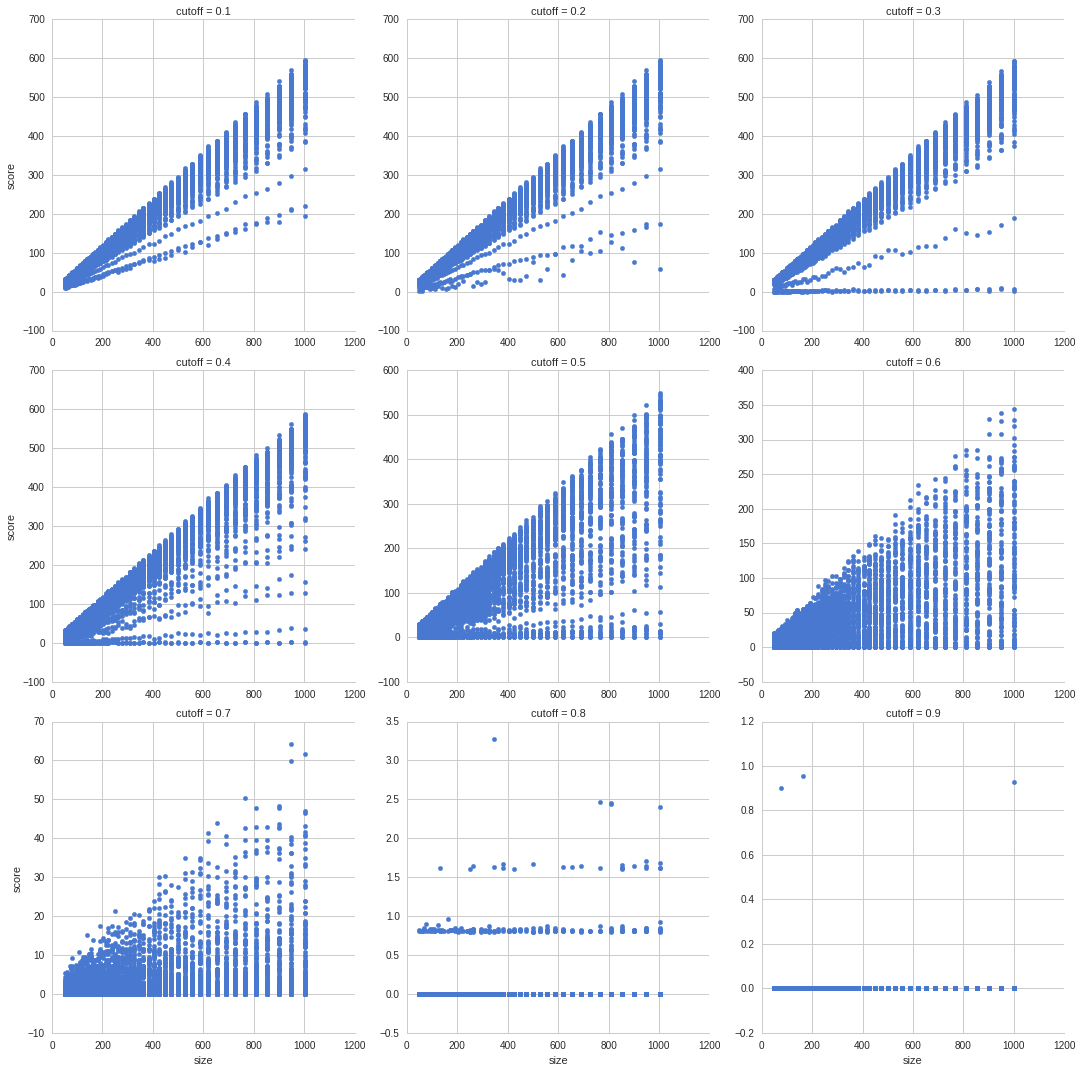

In [10]:
grid = sns.FacetGrid(all_data, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid = (grid.map(plt.scatter, "size", "score").add_legend())
grid.savefig("../figures/supplementary/" + method + "_random_scores.pdf", bbox_inches="tight");

In [11]:
cutoff_groups = all_data.groupby(["cutoff", "size"])

In [12]:
means = cutoff_groups.mean()
means.reset_index(inplace=True)
means.head()

,cutoff,size,score
0,0.1,50.0,26.335548
1,0.1,53.0,27.571062
2,0.1,56.0,29.050133
3,0.1,59.0,29.955315
4,0.1,62.0,32.262703


In [13]:
stdev = cutoff_groups.std()
stdev.reset_index(inplace=True)
stdev.head()

,cutoff,size,score
0,0.1,50.0,3.602507
1,0.1,53.0,3.656705
2,0.1,56.0,3.884354
3,0.1,59.0,3.892973
4,0.1,62.0,4.337784


In [14]:
def raw_mean(x, a):
    return a*x

def raw_std(x, a, b):
    return a*(x**b)

In [15]:
params = {}

for c in cutoffs:
    params[c] = {}
    tmp = means[means["cutoff"] == c]
    x = tmp["size"]
    y = tmp["score"]
    try:
        best_vals, covar = curve_fit(raw_mean, x, y, p0=[1.0])
        params[c]["mean"] = list(best_vals)
    except:
        print "cannot find avg params for c == %s" % c
        del params[c]
        continue

    tmp = stdev[stdev["cutoff"] == c]
    x = tmp["size"]
    y = tmp["score"]
    try:
        best_vals, covar = curve_fit(raw_std, x, y, p0=[1.0, 1.0])
        params[c]["std"] = list(best_vals)
    except:
        print "cannot find std params for c == %s" % c
        del params[c]

cannot find std params for c == 0.9


In [16]:
params

{0.1: {'mean': [0.5159233618544945],
  'std': [0.065721246042766218, 1.0041270621194316]},
 0.2: {'mean': [0.51435096527661661],
  'std': [0.073688409402958538, 1.000481335832502]},
 0.3: {'mean': [0.50794896024421599],
  'std': [0.090981737144133837, 1.003845284356937]},
 0.4: {'mean': [0.47684284024903478],
  'std': [0.11357077663876262, 1.0075073236733125]},
 0.5: {'mean': [0.35243589067397618],
  'std': [0.15171776529129677, 1.0032741708196942]},
 0.6: {'mean': [0.12912561930713484],
  'std': [0.091999665505029526, 1.0024363355248149]},
 0.7: {'mean': [0.01147932974681376],
  'std': [0.024873511449353243, 0.90598347097934473]},
 0.8: {'mean': [0.00011228328162595625],
  'std': [0.0053311643050306407, 0.6042358339370425]}}

In [17]:
f = open(("../data/statistical_model/" + method + ".params"), "w")
f.write(str(params))
f.close()

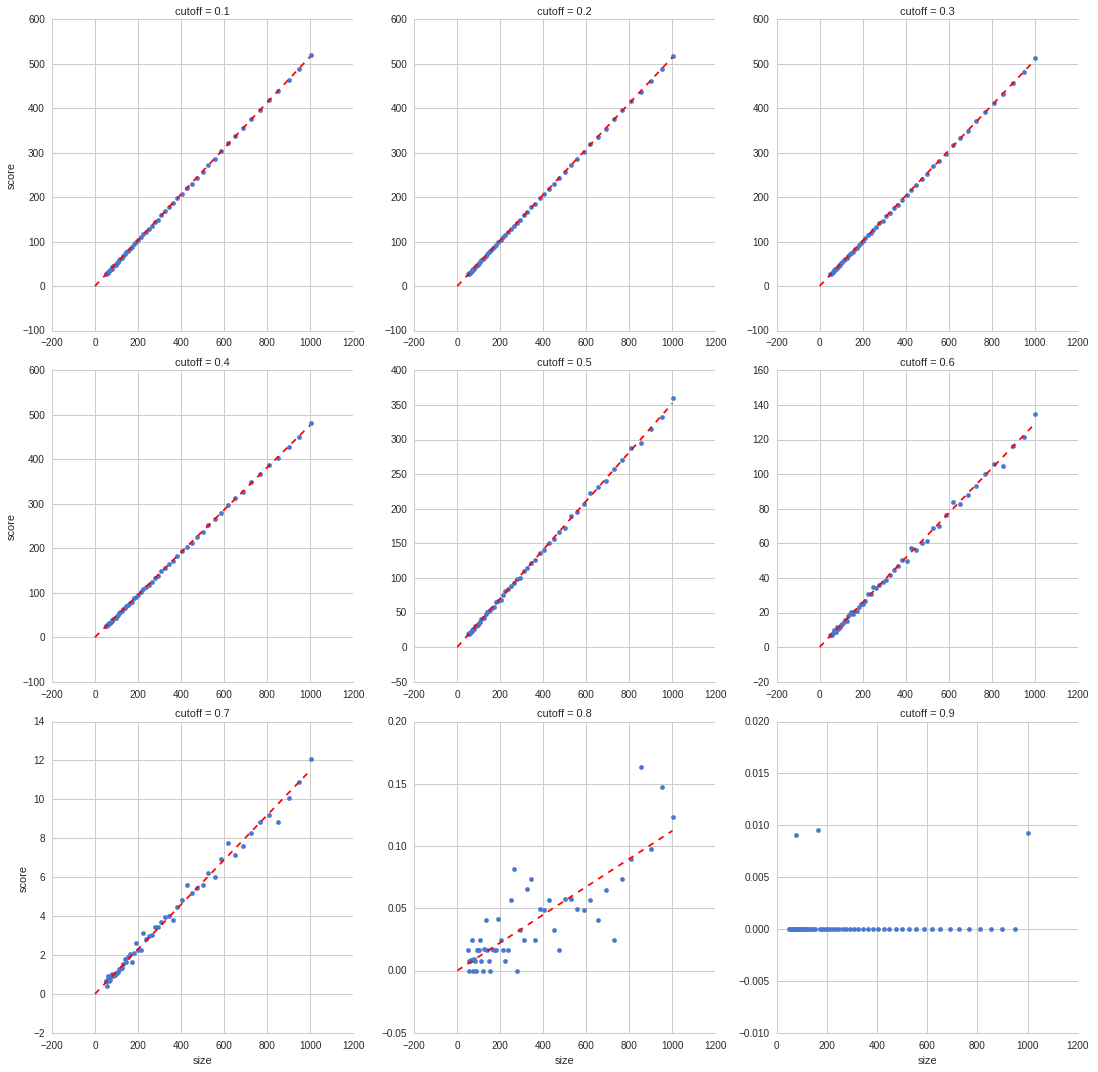

In [18]:
j = 0
grid_mean = sns.FacetGrid(means, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid_mean = (grid_mean.map(plt.scatter, "size", "score").add_legend())
for ax in grid_mean.axes.flat:
    cutoff = cutoffs[j]
    if cutoff in params:
        x = np.linspace(0,1000)
        ax.plot(x, raw_mean(x, *params[cutoff]["mean"]), c="red", ls="--")
    j += 1
grid_mean.add_legend();
grid_mean.savefig("../figures/supplementary/" + method + "_random_mean.pdf", bbox_inches="tight")

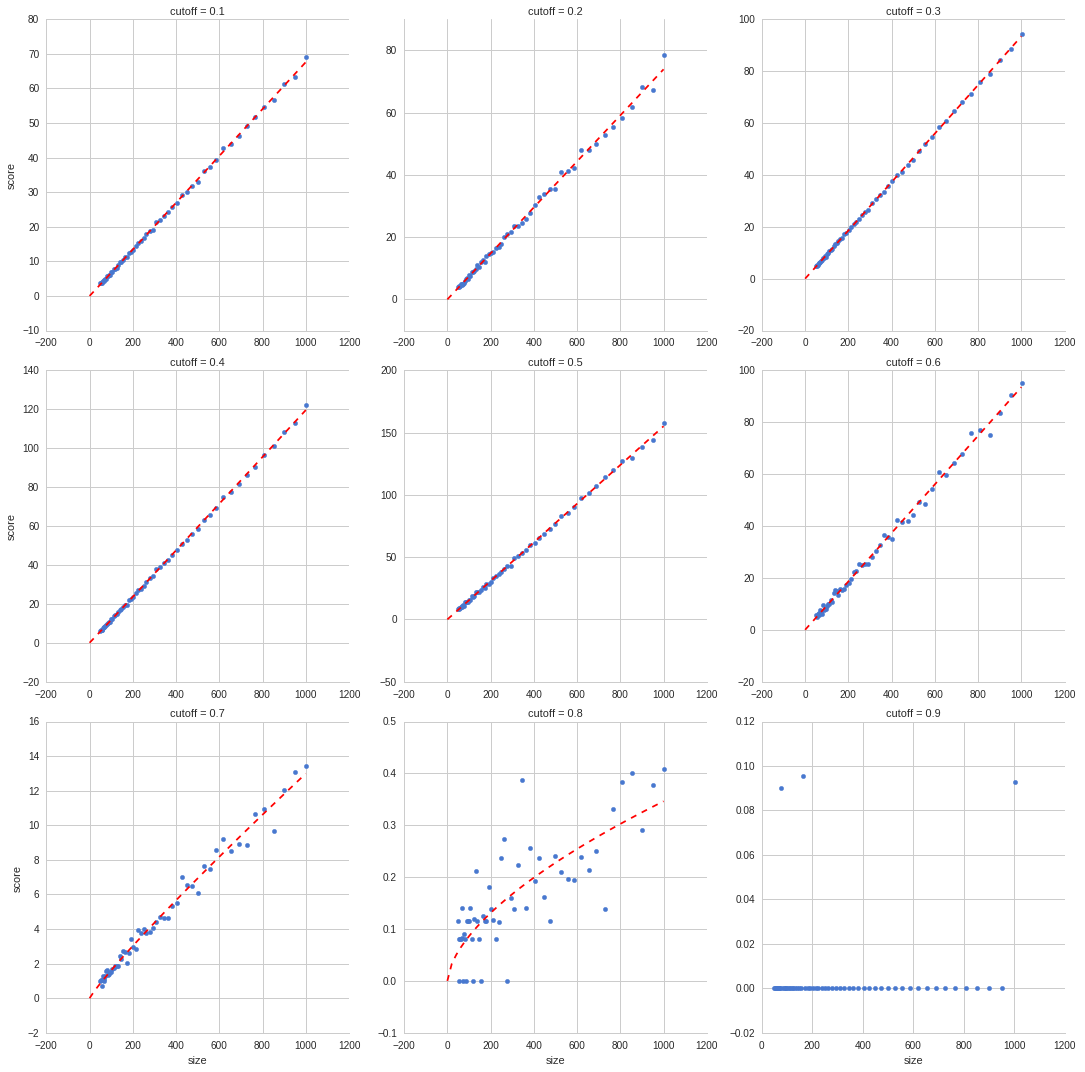

In [19]:
j = 0
grid_std = sns.FacetGrid(stdev, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid_std = grid_std.map(plt.scatter, "size", "score")
for ax in grid_std.axes.flat:
    cutoff = cutoffs[j]
    if cutoff in params:
        x = np.linspace(0,1000)
        ax.plot(x, raw_std(x, *params[cutoff]["std"]), c="red", ls="--")
    j += 1
grid_std.add_legend();
grid_std.savefig("../figures/supplementary/" + method + "_random_sd.pdf", bbox_inches="tight")

In [20]:
def normalize(row):
    cutoff = row["cutoff"]
    if cutoff in params:
        size = row["size"]
        score = row["score"]
        z_score = ((row["score"] - raw_mean(size, *params[cutoff]["mean"])) / 
                    raw_std(size, *params[cutoff]["std"]))
    else:
        z_score = np.nan
    return z_score

In [21]:
all_data["z_score"] = all_data.apply(normalize, axis=1)

In [22]:
all_data = all_data.dropna()

In [23]:
np.mean(all_data["z_score"]), np.std(all_data["z_score"])

(0.0010387330052454495, 1.0227162717194613)

In [24]:
beta = math.sqrt(6.0) / math.pi
mi = -0.5772156649*beta

In [25]:
values = all_data["z_score"]
bins = np.arange(np.min(values), np.max(values), 1)
y_real, bin_edges = np.histogram(values, bins=bins)
y_real = y_real / float(len(values))
x = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

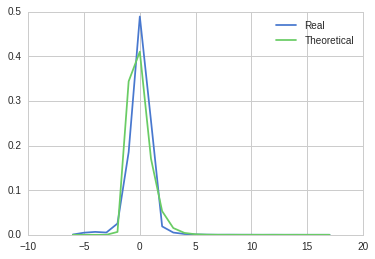

In [26]:
f, ax = plt.subplots()
ax.plot(x, y_real, label="Real")
ax.plot(x, gumbel(x, mi, beta), label="Theoretical")
ax.legend()
f.savefig("../figures/supplementary/" + method + "_fit.pdf", bbox_inches="tight");

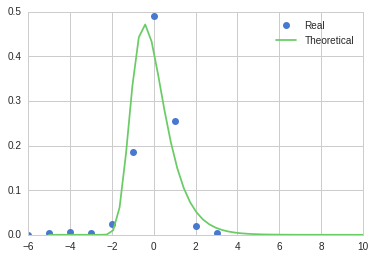

In [27]:
f, ax = plt.subplots()
ax.plot(x[:10], y_real[:10], 'o', label="Real")
x_smooth = np.linspace(-5, 10)
ax.plot(x_smooth, gumbel(x_smooth, mi, beta), label="Theoretical")
ax.legend()
f.savefig("../figures/supplementary/" + method + "_fit_notail.pdf", bbox_inches="tight");

# Results

In [28]:
def pvalue(z):
    z = np.array(z)
    x = -np.exp(-z * math.pi / math.sqrt(6) - 0.5772156649)
    idx = np.where(z < 28)[0]
    res = np.empty_like(z)
    res = -(x + (x**2)/2.0 + (x**3)/6.0)
    res[idx] = 1.0 - np.exp(x[idx])
    return res

In [29]:
targets = []
datasets = {}

for i in glob("../data/results/"+method+"/*tab.bz2"):
    #print i
    name = i.split('/')[-1].split('.')[0]
    targets.append(name)
    datasets[name] = pd.read_table(i)

In [30]:
print targets

['SCN5A', 'CRHR2', 'MC3R', 'ADORA3', 'TBXA2R', 'BDKRB2', 'PDE3A', 'CACNA1C', 'EDNRB', 'PDE4D', 'BDKRB1', 'GPR109A', 'ADRB1', 'HRH2', 'CACNA1B', 'AVPR1A', 'PTGS1', 'NPY2R', 'MLN', 'NR1I2', 'SLC29A1', 'AVPR2', 'NTSR1', 'MAOA', 'GIPR', 'NPY1R']


In [31]:
drug_targets = pd.read_csv("../data/drug_targets.csv", index_col=0)
drug_targets.head()

,drug,target,pred
5,Acebutolol,ADRB2,old
6,Acebutolol,ADRB1,old
9,Acetaminophen,PTGS1,old
17,Acetaminophen,PTGS2,old
40,Acetophenazine,DRD1,old


In [32]:
np.sum(drug_targets["pred"] == "new")

150

In [33]:
np.sum(drug_targets["pred"] == "old")

1079

In [34]:
np.sum(drug_targets["pred"] == "drugbank")

82

In [35]:
trivial = pd.read_csv("../data/trivial_hits.csv", index_col=0)
chemb_low_activity = pd.read_csv("../data/chembl_low_activity_hits.csv", index_col=0)

## Raw scores

In [36]:
all_data = pd.DataFrame(columns=["target", "drug", "cutoff", "score", "size"])

In [37]:
cutoffs.remove(0.9)
cnum = len(cutoffs)

In [38]:
cutoffs, cnum, method, len(targets)

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 8, 'USRCAT_30', 26)

In [39]:
for t in targets:
    print t
    score(datasets[t], cutoffs)
    size = datasets[t].shape[1] - cnum - 1
    for i in xrange(cnum):
        col = colnames[i]
        cutoff = cutoffs[i]
        tmp = datasets[t][["name", col]]
        tmp.columns = ["drug", "score"]
        tmp["target"] = t
        tmp["cutoff"] = cutoff
        tmp["size"] = datasets[t].shape[1] - cnum - 1
        all_data = pd.concat([all_data, tmp])

print all_data.shape
all_data.head()

SCN5A
CRHR2
MC3R
ADORA3
TBXA2R
BDKRB2
PDE3A
CACNA1C
EDNRB
PDE4D
BDKRB1
GPR109A
ADRB1
HRH2
CACNA1B
AVPR1A
PTGS1
NPY2R
MLN
NR1I2
SLC29A1
AVPR2
NTSR1
MAOA
GIPR
NPY1R
(136448, 5)


,cutoff,drug,score,size,target
0,0.1,Acarbose,22.997580,61.0,SCN5A
1,0.1,Acebutolol,30.962193,61.0,SCN5A
2,0.1,Aceclofenac,31.217526,61.0,SCN5A
3,0.1,Acenocoumarol,33.380744,61.0,SCN5A
4,0.1,Acetaminophen,24.919712,61.0,SCN5A


## Z-scores, p-values, e-values

In [40]:
all_data["z_score"] = all_data.apply(normalize, axis=1)
all_data = all_data.dropna()
all_data.head()

,cutoff,drug,score,size,target,z_score
0,0.1,Acarbose,22.997580,61.0,SCN5A,-2.078125
1,0.1,Acebutolol,30.962193,61.0,SCN5A,-0.124861
2,0.1,Aceclofenac,31.217526,61.0,SCN5A,-0.062242
3,0.1,Acenocoumarol,33.380744,61.0,SCN5A,0.468271
4,0.1,Acetaminophen,24.919712,61.0,SCN5A,-1.606736


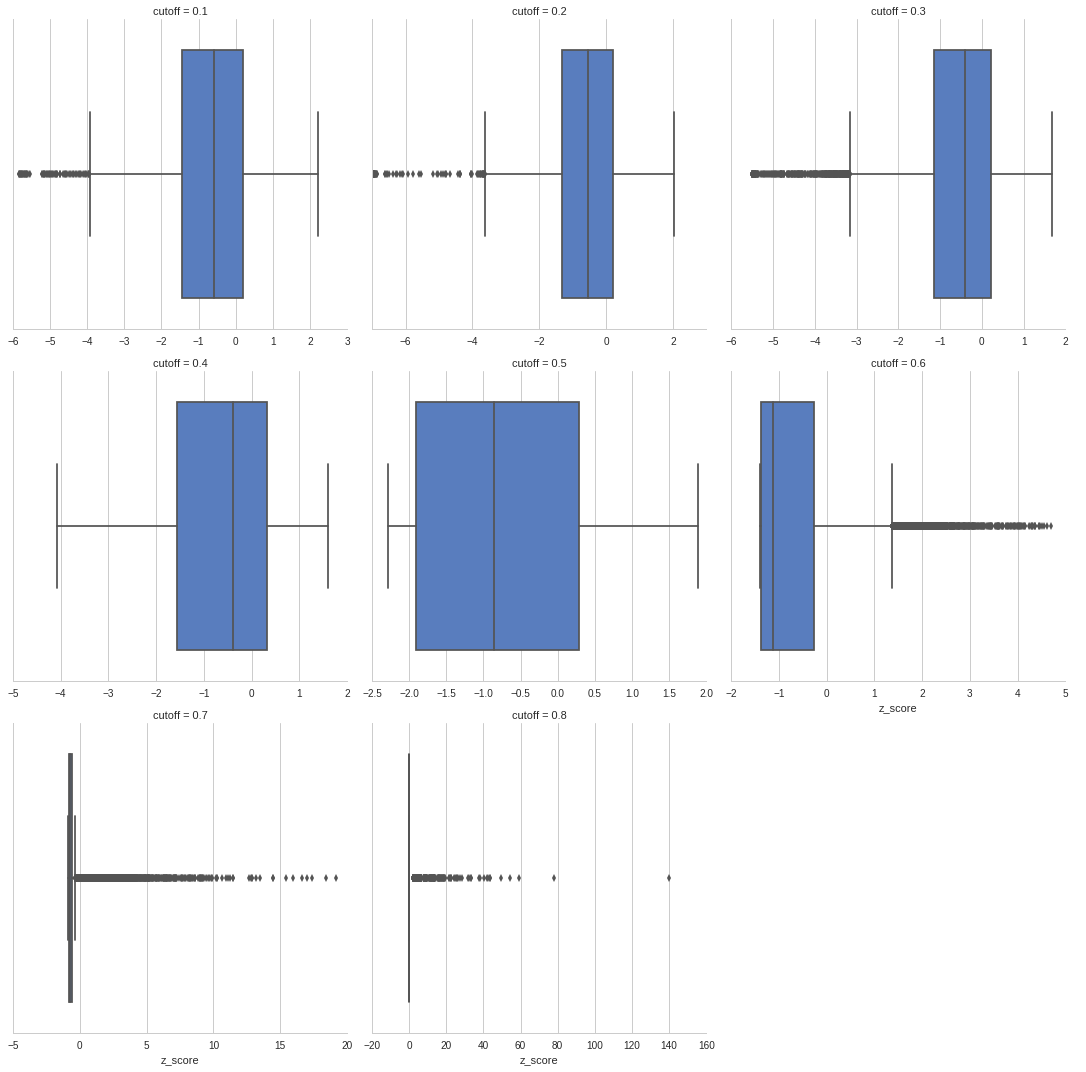

In [41]:
grid_z = sns.FacetGrid(all_data, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False,
                                      legend_out=True)
grid_z = (grid_z.map(sns.boxplot, "z_score").add_legend())
grid_z;

In [42]:
all_data["p_value"] = pvalue(all_data["z_score"])
all_data.head()

,cutoff,drug,score,size,target,z_score,p_value
0,0.1,Acarbose,22.997580,61.0,SCN5A,-2.078125,0.999687
1,0.1,Acebutolol,30.962193,61.0,SCN5A,-0.124861,0.482617
2,0.1,Aceclofenac,31.217526,61.0,SCN5A,-0.062242,0.455625
3,0.1,Acenocoumarol,33.380744,61.0,SCN5A,0.468271,0.265053
4,0.1,Acetaminophen,24.919712,61.0,SCN5A,-1.606736,0.987825


In [43]:
N = 73 * 656
N

47888

In [44]:
all_data["e_value"] = all_data["p_value"] * N
all_data.head()

,cutoff,drug,score,size,target,z_score,p_value,e_value
0,0.1,Acarbose,22.997580,61.0,SCN5A,-2.078125,0.999687,47873.012891
1,0.1,Acebutolol,30.962193,61.0,SCN5A,-0.124861,0.482617,23111.548806
2,0.1,Aceclofenac,31.217526,61.0,SCN5A,-0.062242,0.455625,21818.993337
3,0.1,Acenocoumarol,33.380744,61.0,SCN5A,0.468271,0.265053,12692.842485
4,0.1,Acetaminophen,24.919712,61.0,SCN5A,-1.606736,0.987825,47304.957890


In [45]:
all_data.to_csv("../data/results/"+method+"_all_results.csv")

## Summary

In [46]:
e_range = np.arange(-10, 1)
e_range

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0])

In [47]:
predictions = {e: {t: set() for t in targets} for e in e_range}

for e in e_range:
    pred = all_data[(all_data["e_value"] <= 10**e)].groupby("target")
    for t, group in pred:
        predictions[e][t] = predictions[e][t] | set(list(group["drug"]))

low_act = {}
for t in targets:
    low_act[t] = set(list(chemb_low_activity[(chemb_low_activity["target"] == t)]["drug"].unique()))

triv = {}
for t in targets:
    triv[t] = set(list(trivial[(trivial["target"] == t)]["drug"].unique()))

known = {}
for t in targets:
    known[t] = (set(list(drug_targets[(drug_targets["target"] == t)]["drug"].unique())) | triv[t] | low_act[t])

In [48]:
summary = pd.DataFrame(columns=["e_value", "target", "pred", "true", "not trivial", "low activity", "false",
                                "not found"])

i = 0
for e in e_range:
    for t in targets:
        pr = predictions[e][t]
        tr = len(pr & known[t])
        nt = len((pr & known[t]) - triv[t])
        la = len(pr & low_act[t])
        f = len(pr - known[t])
        nf = len((known[t] - pr))        
        summary.loc[i] = [10**e, t, len(pr), tr, nt, la, f, nf]
        i += 1

summary.head()

,e_value,target,pred,true,not trivial,low activity,false,not found
0,1.000000e-10,SCN5A,0.0,0.0,0.0,0.0,0.0,20.0
1,1.000000e-10,CRHR2,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000e-10,MC3R,0.0,0.0,0.0,0.0,0.0,5.0
3,1.000000e-10,ADORA3,0.0,0.0,0.0,0.0,0.0,15.0
4,1.000000e-10,TBXA2R,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
summary.to_csv("../data/results/"+method+"_summary.csv")

In [50]:
summary_e = summary.groupby("e_value").sum()[["pred", "true", "not trivial", "low activity", "false", "not found"]]
summary_e

,pred,true,not trivial,low activity,false,not found
e_value,,,,,,
1.000000e-10,19.0,11.0,5.0,0.0,8.0,226.0
1.000000e-09,24.0,13.0,6.0,0.0,11.0,224.0
1.000000e-08,27.0,14.0,7.0,0.0,13.0,223.0
1.000000e-07,30.0,16.0,7.0,0.0,14.0,221.0
1.000000e-06,34.0,18.0,8.0,0.0,16.0,219.0
1.000000e-05,47.0,26.0,12.0,3.0,21.0,211.0
1.000000e-04,62.0,29.0,14.0,3.0,33.0,208.0
1.000000e-03,76.0,32.0,14.0,3.0,44.0,205.0
1.000000e-02,101.0,38.0,17.0,4.0,63.0,199.0


In [51]:
summary_e.to_csv("../data/results/"+method+"_summary_e.csv")

---

## Summary for DeCAF

In [52]:
tmp = pd.read_csv("../data/results/DeCAF_all_results.csv", index_col=0)
tmp = tmp.loc[tmp.apply(lambda x: (x["target"] in targets) and (x["cutoff"] != 0.9), axis=1)]

In [53]:
tmp.head()

,cutoff,drug,score,size,target,z_score,p_value,e_value
0,0.1,Acarbose,22.233594,61.0,SCN5A,1.216231,0.111302,5330.016529
1,0.1,Acebutolol,20.908136,61.0,SCN5A,0.782845,0.185937,8904.133727
2,0.1,Aceclofenac,25.837062,61.0,SCN5A,2.394458,0.025701,1230.779022
3,0.1,Acenocoumarol,22.027414,61.0,SCN5A,1.148816,0.120722,5781.125067
4,0.1,Acetaminophen,22.983463,61.0,SCN5A,1.461416,0.082552,3953.259373


In [54]:
predictions = {e: {t: set() for t in targets} for e in e_range}

for e in e_range:
    pred = tmp[(tmp["e_value"] <= 10**e)].groupby("target")
    for t, group in pred:
        predictions[e][t] = predictions[e][t] | set(list(group["drug"]))

low_act = {}
for t in targets:
    low_act[t] = set(list(chemb_low_activity[(chemb_low_activity["target"] == t)]["drug"].unique()))

triv = {}
for t in targets:
    triv[t] = set(list(trivial[(trivial["target"] == t)]["drug"].unique()))

known = {}
for t in targets:
    known[t] = (set(list(drug_targets[(drug_targets["target"] == t)]["drug"].unique())) | triv[t] | low_act[t])

In [55]:
summary = pd.DataFrame(columns=["e_value", "target", "pred", "true", "not trivial", "low activity", "false",
                                "not found"])

i = 0
for e in e_range:
    for t in targets:
        pr = predictions[e][t]
        tr = len(pr & known[t])
        nt = len((pr & known[t]) - triv[t])
        la = len(pr & low_act[t])
        f = len(pr - known[t])
        nf = len((known[t] - pr))        
        summary.loc[i] = [10**e, t, len(pr), tr, nt, la, f, nf]
        i += 1

summary.head()

,e_value,target,pred,true,not trivial,low activity,false,not found
0,1.000000e-10,SCN5A,0.0,0.0,0.0,0.0,0.0,20.0
1,1.000000e-10,CRHR2,3.0,0.0,0.0,0.0,3.0,0.0
2,1.000000e-10,MC3R,0.0,0.0,0.0,0.0,0.0,5.0
3,1.000000e-10,ADORA3,5.0,1.0,1.0,0.0,4.0,14.0
4,1.000000e-10,TBXA2R,4.0,0.0,0.0,0.0,4.0,0.0


In [56]:
summary_e = summary.groupby("e_value").sum()[["pred", "true", "not trivial", "low activity", "false", "not found"]]
summary_e

,pred,true,not trivial,low activity,false,not found
e_value,,,,,,
1.000000e-10,100.0,40.0,18.0,2.0,60.0,197.0
1.000000e-09,110.0,46.0,20.0,2.0,64.0,191.0
1.000000e-08,120.0,50.0,20.0,2.0,70.0,187.0
1.000000e-07,141.0,54.0,23.0,2.0,87.0,183.0
1.000000e-06,158.0,54.0,23.0,2.0,104.0,183.0
1.000000e-05,177.0,55.0,23.0,2.0,122.0,182.0
1.000000e-04,202.0,59.0,24.0,2.0,143.0,178.0
1.000000e-03,253.0,69.0,31.0,4.0,184.0,168.0
1.000000e-02,305.0,79.0,39.0,8.0,226.0,158.0


In [57]:
summary_e.to_csv("../data/results/DeCAF_subset_summary_e.csv")